In [1]:
import re
import csv

import tellurium as te
import pandas as pd
import seaborn as sns

fn_ant = '../model/euromix_man_only_liver.ant'
fn_sbml = fn_ant.replace('.ant','.sbml')

In [2]:
r_out = pd.read_csv('../tmp/r_out_only_liver.csv').drop(columns=['Unnamed: 0'])
q_cols = {'1':'QVen', '2':'QArt', '6':'QLiver',
                      '11':'QGut', '12':'QExcret', '13':'QMetab'}
r_out.rename(columns=q_cols, inplace=True)
long_r = pd.melt(r_out[['time']+list(q_cols.values())], id_vars=['time'], value_vars=q_cols.values(), 
                 var_name='quantity', value_name='value')
long_r['src'] = 'R'

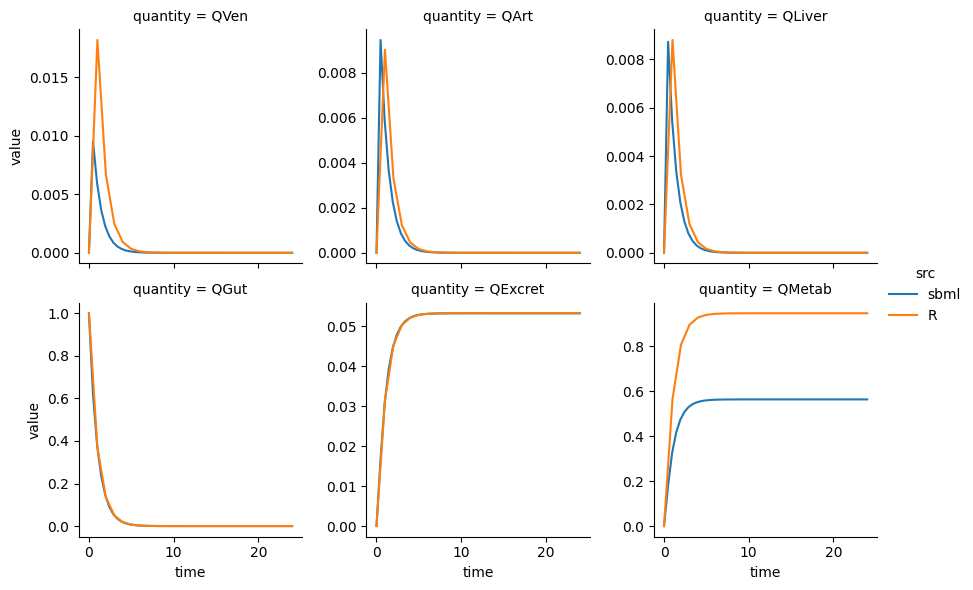

In [3]:
def compare(results):
    names = [re.sub(r'\[(.*?)\]', r'\1', name) for name in results.colnames]
    df = pd.DataFrame(results, columns=names).fillna(0)
    long_df = pd.melt(df, id_vars=['time'], value_vars=df.columns[1:], var_name='quantity', value_name='value')
    long_df['src'] = 'sbml'
    all_df = pd.concat((long_df, long_r))
    g = sns.FacetGrid(all_df, col='quantity', hue='src', col_wrap=3, sharey=False,
                     col_order=q_cols.values())
    g.map(sns.lineplot, 'time', 'value')
    g.add_legend()
    
r = te.loada(fn_ant)
r.QGut = 1
compare(r.simulate(0, 24))


There is a big difference between the amount of metabolites in the R and sbml model.

# Some analysis

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad, trapz

In [14]:
# run the model again
r = te.loada(fn_ant)
r.QGut = 1
results = r.simulate(0, 24)
names = [re.sub(r'\[(.*?)\]', r'\1', name) for name in results.colnames]
df = pd.DataFrame(results, columns=names).fillna(0)

We know that the total amount of substance entering the system is equal to the initial bolus $QGut(0) = 1$. 

In [47]:
total_sbml = df.QMetab.values[-1] + df.QExcret.values[-1]
total_r = r_out.QMetab.values[-1] + r_out.QExcret.values[-1]
print(f'Total amount of substance:\n\t- sbml: {total_sbml}\n\t- R:    {total_r}')

Total amount of substance:
	- sbml: 0.6167675748340125
	- R:    0.9999999819839142


It looks like the results of the R simulations are correct and sbm simulation is leaky.

# Test solver

## Compare solvers

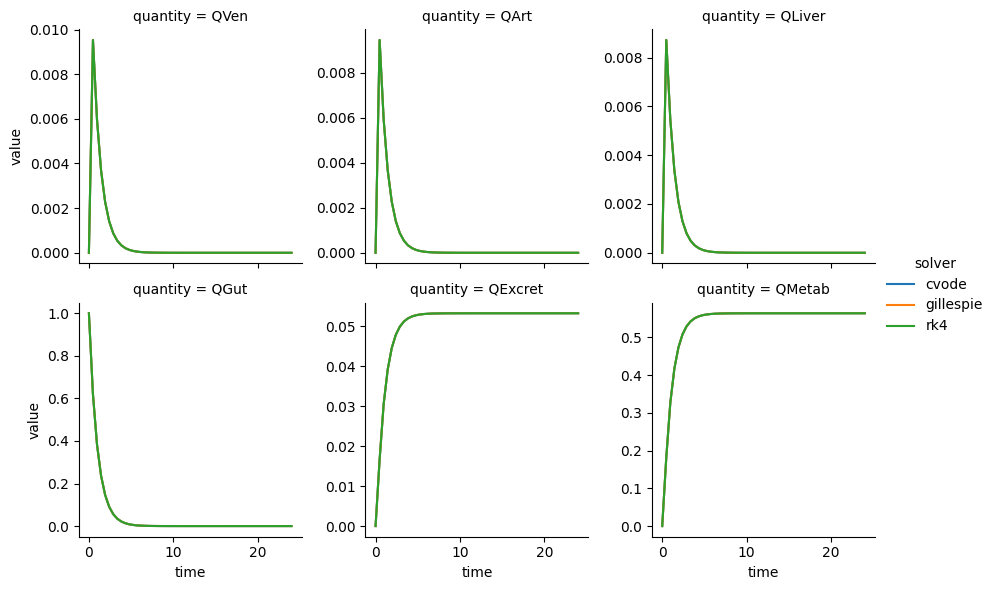

In [50]:
solvers = ['cvode', 'gillespie', 'rk4']
names = [re.sub(r'\[(.*?)\]', r'\1', name) for name in results.colnames]
df_all = pd.DataFrame()

for solver in solvers:
    r = te.loada(fn_ant)
    r.QGut = 1
    r.setIntegrator = solver
    results = r.simulate(0, 24)
    df = pd.DataFrame(results, columns=names).fillna(0)
    long_df = pd.melt(df, id_vars=['time'], value_vars=df.columns[1:], var_name='quantity', value_name='value')
    long_df['solver'] = solver
    df_all = pd.concat((df_all, long_df))
g = sns.FacetGrid(df_all, col='quantity', hue='solver', col_wrap=3, sharey=False,
                 col_order=q_cols.values())
g.map(sns.lineplot, 'time', 'value')
g.add_legend()


## Turn of/on variable step size

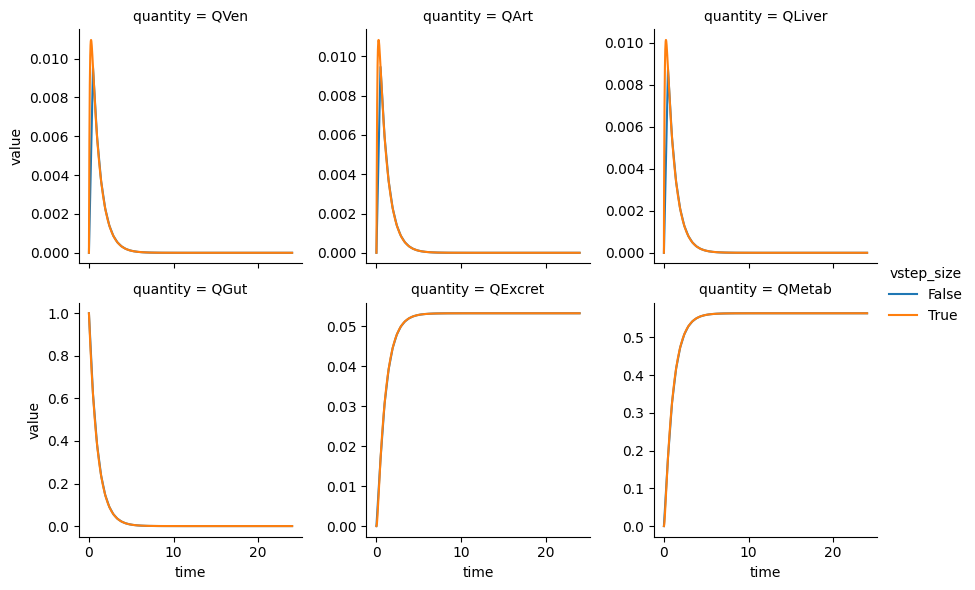

In [56]:
names = [re.sub(r'\[(.*?)\]', r'\1', name) for name in results.colnames]
df_all = pd.DataFrame()

for vstep_size in [True, False]:
    r = te.loada(fn_ant)
    r.QGut = 1
    r.setIntegrator = 'cvode'
    r.integrator.variable_step_size = vstep_size
    results = r.simulate(0, 24)
    df = pd.DataFrame(results, columns=names).fillna(0)
    long_df = pd.melt(df, id_vars=['time'], value_vars=df.columns[1:], var_name='quantity', value_name='value')
    long_df['vstep_size'] = vstep_size
    df_all = pd.concat((df_all, long_df))
g = sns.FacetGrid(df_all, col='quantity', hue='vstep_size', col_wrap=3, sharey=False,
                 col_order=q_cols.values())
g.map(sns.lineplot, 'time', 'value')
g.add_legend()

## Tolerances

### Relative tolerance

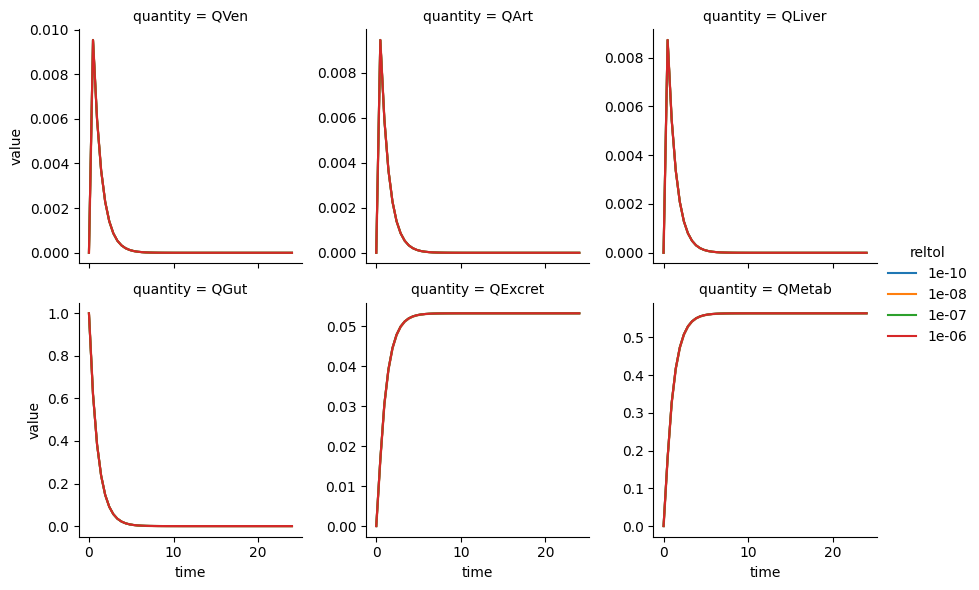

In [58]:
relative_tolerance = [1e-6, 1e-8, 1e-10]
for reltol in relative_tolerance:
    r = te.loada(fn_ant)
    r.QGut = 1
    r.setIntegrator = 'cvode'
    r.integrator.variable_step_size = True        
    r.integrator.relative_tolerance = reltol
    results = r.simulate(0, 24)
    df = pd.DataFrame(results, columns=names).fillna(0)
    long_df = pd.melt(df, id_vars=['time'], value_vars=df.columns[1:], var_name='quantity', value_name='value')
    long_df['reltol'] = reltol
    df_all = pd.concat((df_all, long_df))
g = sns.FacetGrid(df_all, col='quantity', hue='reltol', col_wrap=3, sharey=False,
                 col_order=q_cols.values())
g.map(sns.lineplot, 'time', 'value')
g.add_legend()

### Absoluate tolerance

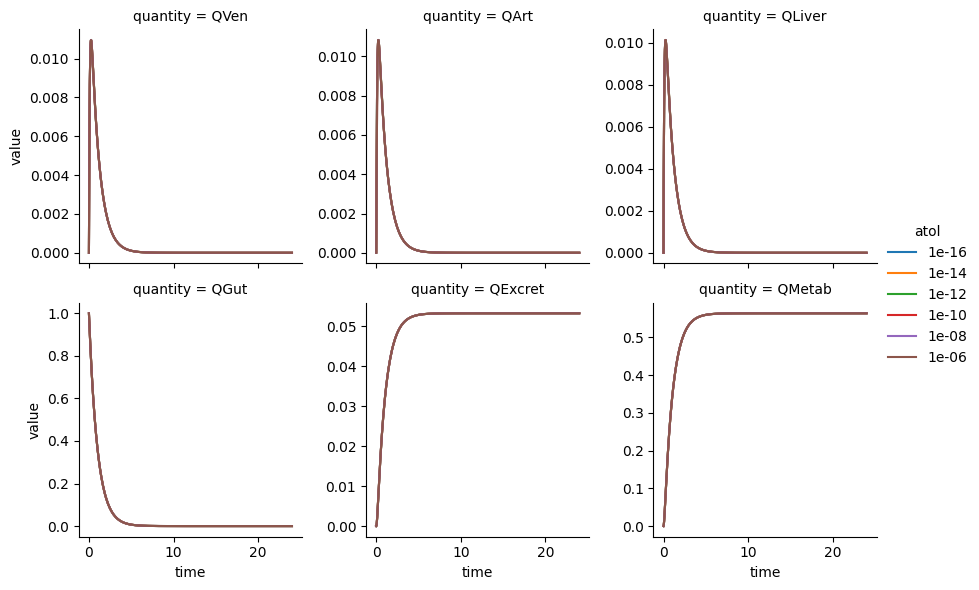

In [66]:
absolute_tolerance = [1e-16, 1e-14, 1e-12]
for atol in absolute_tolerance:
    r = te.loada(fn_ant)
    r.QGut = 1
    r.setIntegrator = 'cvode'
    r.integrator.variable_step_size = True    
    r.integrator.absolute_tolerance = atol
    results = r.simulate(0, 24)
    df = pd.DataFrame(results, columns=names).fillna(0)
    long_df = pd.melt(df, id_vars=['time'], value_vars=df.columns[1:], var_name='quantity', value_name='value')
    long_df['atol'] = atol
    df_all = pd.concat((df_all, long_df))
g = sns.FacetGrid(df_all, col='quantity', hue='atol', col_wrap=3, sharey=False,
                 col_order=q_cols.values())
g.map(sns.lineplot, 'time', 'value')
g.add_legend()

### Absolute and relative tolerance

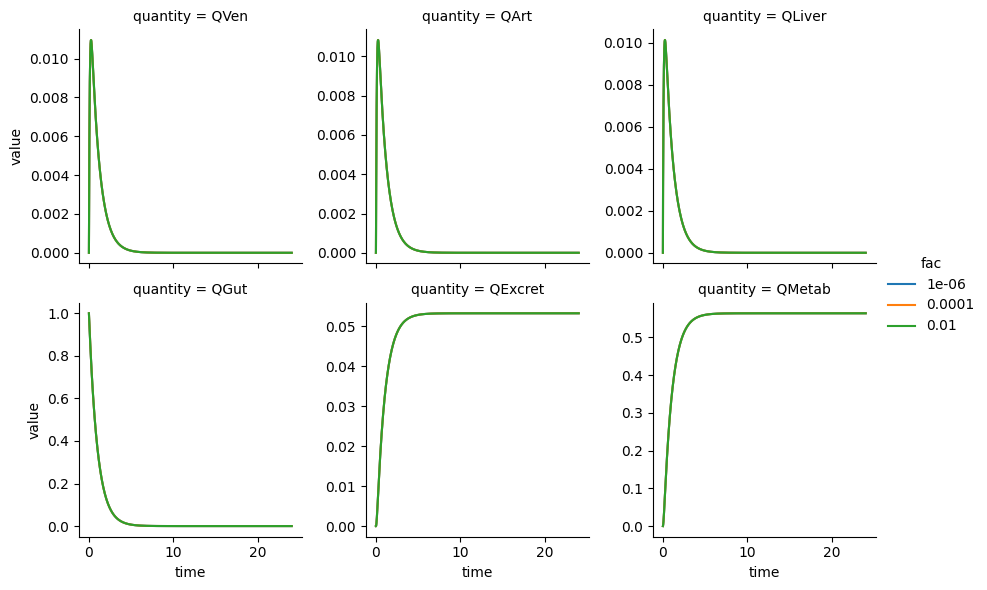

In [72]:
fac = [1e-2, 1e-4, 1e-6]
for fac in fac:
    r = te.loada(fn_ant)
    r.QGut = 1
    r.setIntegrator = 'cvode'
    r.integrator.variable_step_size = True    
    r.integrator.absolute_tolerance *= fac
    r.integrator.relative_tolerance *= fac
    results = r.simulate(0, 24)
    df = pd.DataFrame(results, columns=names).fillna(0)
    long_df = pd.melt(df, id_vars=['time'], value_vars=df.columns[1:], var_name='quantity', value_name='value')
    long_df['fac'] = fac
    df_all = pd.concat((df_all, long_df))
g = sns.FacetGrid(df_all, col='quantity', hue='fac', col_wrap=3, sharey=False,
                 col_order=q_cols.values())
g.map(sns.lineplot, 'time', 'value')
g.add_legend()

## Conclusion

To my surprise none of the solver settings affect the outcome. This suggests, to me, that the solver is not the issue.